# Sampling rate for Face Detection

All videos were downloaded at 30 FPS. Using this frame rate for detection gives us a 3:1 speedup from real time. Considering the large amount of footage required to process, further speedup is required. Another improvement is related to a smooth transition between frames. A phenomenon called jittering.

In [1]:
%matplotlib inline
import json
from datetime import timedelta
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
SAMPLE_LENGTH = 5.0
SAMPLE_NUM = 1000

experiments = [
    {'folder': r'D:/downloads/tracks@30FPS', 'label': '30FPS'},
]

In [3]:
for d in experiments:
    d['video_length'] = []
    d['time_detecting'] = []
    d['width'] = []
    d['height'] = []
    d['track_time'] = []
    d['track_bbox'] = []
    d['track_kpts'] = []
    d['track_length'] = []
    
    for track_file in Path(d['folder']).glob('**/*.tracks.json'):
        with track_file.open('r', encoding='utf8') as fp:
            track_file = json.load(fp)
        
        if len(track_file['tracks']) == 0:
            continue
        
        track_time, track_bbox, track_kpts = zip(*[(t['time'], t['bbox'], t['kpts']) for t in track_file['tracks'].values()])
        
        track_time = list(track_time)
        track_bbox = list(track_bbox)
        track_kpts = list(track_kpts)
        track_length = []
        
        # Normalizes tracks to screen center and to the start time.
        for i, (t, b, k) in enumerate(zip(track_time, track_bbox, track_kpts)):
            t = np.float32(t)
            b = np.float32(b).reshape(-1, 2, 2)
            k = np.float32(k).reshape(-1, 5, 2)
            t -= t[0]
            b[:, :, 0] -= 0.5 * track_file['width']
            b[:, :, 1] -= 0.5 * track_file['height']
            k[:, :, 0] -= 0.5 * track_file['width']
            k[:, :, 1] -= 0.5 * track_file['height']
            track_time[i] = t.tolist()
            track_bbox[i] = b.tolist()
            track_kpts[i] = k.tolist()
            track_length.append(t[-1])
        
        # Video data
        d['video_length'].append(track_file['video_duration'])
        d['time_detecting'].append(track_file['detection_duration'])
        d['width'].append(track_file['width'])
        d['height'].append(track_file['height'])
        
        # Track data
        d['track_time'].extend(track_time)
        d['track_bbox'].extend(track_bbox)
        d['track_kpts'].extend(track_kpts)
        d['track_length'].extend(track_length)

    print(f"{d['label']}:")
    print('  - Total video length:', timedelta(seconds=sum(d['video_length'])))
    print('  - Total time detecting:', timedelta(seconds=sum(d['time_detecting'])))
    print('  - Total track length:', timedelta(seconds=sum(d['track_length'])))

30FPS:
  - Total video length: 14:36:48.266667
  - Total time detecting: 12:16:10.141013
  - Total track length: 10:46:27.368095


We take a random sample of videos from the dataset. From these we take 5 second segments of detected bounding boxes. The 30 FPS samples will be our ground truth while subsamples of 15, 7, and 3FPS will be used as contrast. We will use the signal to noise ratio to check on the quality of the signals. We will use interpolation estrategies to complete the missing gaps in detection.

In [4]:
test_time = []
test_bbox = []
test_kpts = []

d = experiments[0]

track_time = d['track_time']
track_bbox = d['track_bbox']
track_kpts = d['track_kpts']

track_length = d['track_length']
num_tracks = len(track_time)

track_samples = (np.random.random(SAMPLE_NUM) * num_tracks).astype(int)
track_start = np.random.random(SAMPLE_NUM) * (np.float32(track_length)[track_samples] - SAMPLE_LENGTH)

for ti, ts in zip(track_samples, track_start):
    t_time = []
    t_bbox = []
    t_kpts = []
    for i in range(len(track_time[ti])):
        if ts <= track_time[ti][i] < ts + SAMPLE_LENGTH:
            t_time.append(track_time[ti][i])
            t_bbox.append(track_bbox[ti][i])
            t_kpts.append(track_kpts[ti][i])
    test_time.append([t - t_time[0] for t in t_time])
    test_bbox.append(t_bbox)
    test_kpts.append(t_kpts)

In [5]:
# Calculate the center of the bbox for all frames and get the average position, normalize the track centers by it.
test_ctrs = []
for bbox in test_bbox:
    bbox = np.float32(bbox)
    ctr = np.sum(bbox, axis=1) * 0.5
    test_ctrs.append(ctr)

In [6]:
def gaussian(x, mu, sigma):
    return (1.0 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

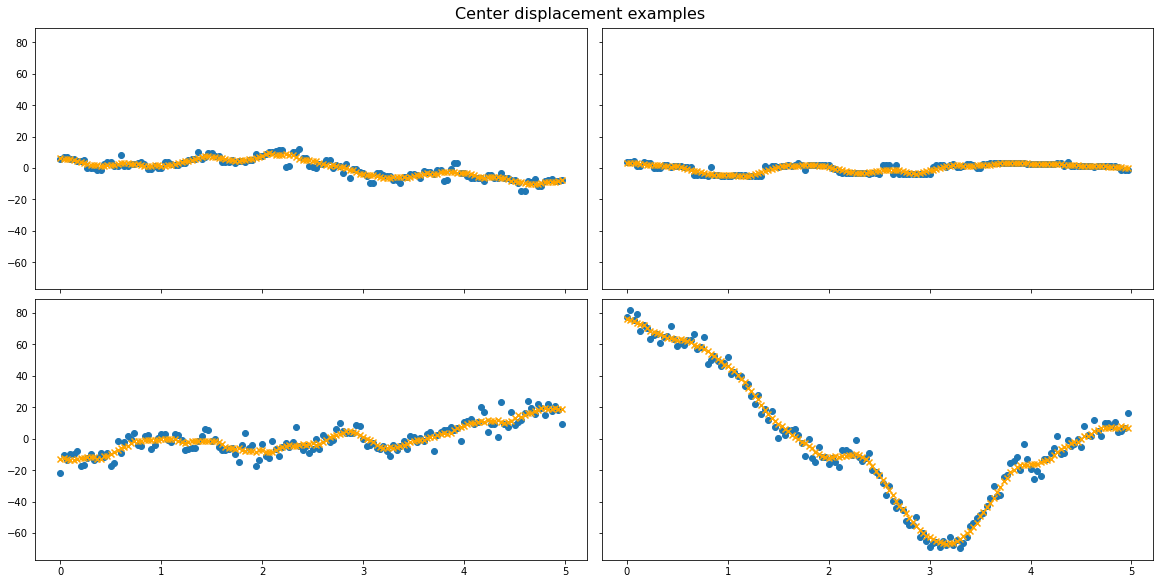

In [7]:
nrows, ncols = (2, 2)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(16, 8), constrained_layout=True)

# TODO: pick representative graphs
_test_time = []
_test_ctrs = []
for i in np.random.random(nrows * ncols):
    i = int(i * len(test_time))
    _test_time.append(test_time[i])
    _test_ctrs.append(test_ctrs[i])

for ax, time, ctrs in zip(axs.flatten(), _test_time, _test_ctrs):
    ctr_dist = np.sqrt(np.sum(ctrs**2, axis=-1))
    ctr_mean = np.mean(ctr_dist)
    
    time = np.float32(time)
    
    ctrs = ctr_dist - ctr_mean
    ax.scatter(time, ctrs)
    
    ctrs_win = []
    for i in range(len(ctrs)):
        istart = max(i-5, 0)
        iend = min(i+5, len(ctrs)-1)
        weights = gaussian(time[istart:iend], time[i], 3)
        ctrs_win.append(np.average(ctrs[istart:iend], weights=weights))
    ctrs_win = np.float32(ctrs_win)
    ax.scatter(time, ctrs_win, color='orange', marker='x')

fig.suptitle('Center displacement examples', fontsize=16)
plt.show()

## Speedup by lowering frame rate

How changes in frame rate affect the speedup. The image size of the processed video affects the results so it is included.

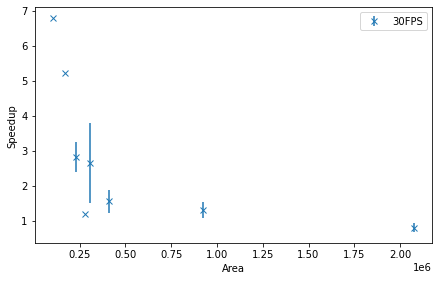

In [8]:
fig = plt.figure()
ax = plt.axes()

for d in experiments:
    all_area = np.float32(d['width']) * np.float32(d['height'])
    all_speedup = np.float32(d['video_length']) / np.float32(d['time_detecting'])
    
    area = np.sort(np.unique(all_area))
    speedup = [np.mean(all_speedup[all_area == i]) for i in area]
    speedup_err = [np.std(all_speedup[all_area == i]) for i in area]
    ax.errorbar(area, speedup, yerr=speedup_err, fmt='x', label=d['label'])
    
    # Order results by area
    # idx = np.argsort(area)
    # area = area[idx]
    # speedup = speedup[idx]
    #ax.scatter(area, speedup, label=d['label'])

fig.tight_layout()
plt.xlabel('Area')
plt.ylabel('Speedup')
plt.legend()
plt.show()

## Interpolation Methods

We try several interpolation methods and check the quality of the signal using the signal to noise ratio.
Will compute the time-normalized difference on consecutive detected centroids, widht and height.